In [64]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.electronic_structure.core import Spin
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
mp_key = "YGuF6wLUiS0cPBcPVPZQwERRrYM11mh7"
mp_id = "mp-22003"

In [49]:
with MPRester(mp_key) as m:
    structure = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id) # Electronic Band Structure
    el_dos = m.get_dos_by_material_id(mp_id) # Electronic Density of States

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
get_plot_bs_and_dos(el_bs,el_dos)

In [68]:
band_gap = el_bs.get_band_gap()
cbm = el_bs.get_cbm() #The Conduction Band Minimum is the lowest energy level in the conduction band
vbm = el_bs.get_vbm() #The Valence Band Maximum is the highest energy level in the valence band
if band_gap['direct']:
    print(f"The material has a direct band gap of {band_gap['energy']} eV.")
else:
    print(f"The material has an indirect band gap of {band_gap['energy']} eV.")
print("Transition : ", band_gap['transition'])
print(f"Conduction Band Minimum (CBM) energy: {cbm['energy']} eV")
print(f"Valence Band Maximum (VBM) energy: {vbm['energy']} eV")

The material has an indirect band gap of 4.0268 eV.
Transition :  Z-L
Conduction Band Minimum (CBM) energy: 3.7634 eV
Valence Band Maximum (VBM) energy: -0.2634 eV


In [93]:
bsplot =BSPlotter(el_bs)
data = bplot.bs_plot_data() 
distances = data.get('distances') 
energy = data.get('energy') 
dist = data.get('ticks').get('distance')
def pente(a,b):
    pente = (abs(a[-1] - a[0])) /(b[-1] - b[0])
    sol = [a[-1],a[0],b[-1],b[0],pente]
    return np.array(sol)
def disp1(num):
    d = len(distances)
    pente_int = np.zeros((d,5))
    for i in range(d): 
        pente_int[i] = pente(energy['1'][i][num], distances[i])
    return(pente_int)
def disp2(pente_int): 
    d = len(distances)
    inter = np.zeros(d)
    for i in range(d):
        inter[i] = pente_int[i][4]
    return(inter)
vbm_band_index = el_bs.get_vbm()['band_index'][Spin.up][0]
bval_max = np.argmax(disp2(disp1(vbm_band_index)))
bval_min = np.argmin(disp2(disp1(vbm_band_index)))
pente_bval_max = disp1(vbm_band_index)[bval_max]
pente_bval_min = disp1(vbm_band_index)[bval_min]
cbm_band_index = el_bs.get_cbm()['band_index'][Spin.up][0]
bcond_max = np.argmax(disp2(disp1(cbm_band_index)))
bcond_min = np.argmin(disp2(disp1(cbm_band_index)))
pente_bcond_max = disp1(cbm_band_index)[bcond_max]
pente_bcond_min = disp1(cbm_band_index)[bcond_min]

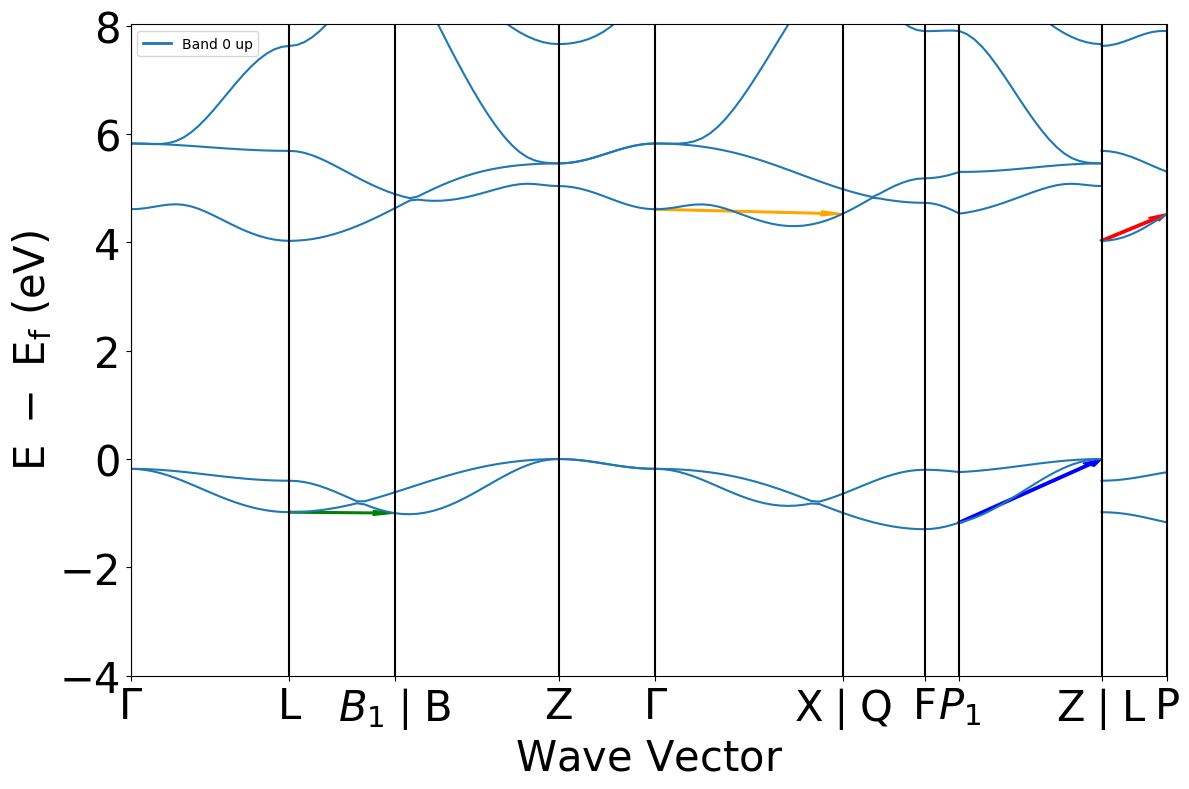

BLEU-La pente maximale pour la bande de valence 1.3006831857425971
VERT-La pente minimale pour la bande de valence  0.025779733454439416
ROUGE-La pente maximale pour la bande de conduction 1.2028299148032051
ORANGE-La pente minimale pour la bande de conduction 0.07200210678375397


In [99]:
bsplot.get_plot(vbm_cbm_marker=False)
plt.arrow(pente_bval_max[3],pente_bval_max[1],pente_bval_max[2]-pente_bval_max[3],pente_bval_max[0]-pente_bval_max[1],color='blue', width = 0.03,length_includes_head = True)
plt.arrow(pente_bval_min[3],pente_bval_min[1],pente_bval_min[2]-pente_bval_min[3],pente_bval_min[0]-pente_bval_min[1],color='green', width = 0.03,length_includes_head = True)
plt.arrow(pente_bcond_max[3],pente_bcond_max[1],pente_bcond_max[2]-pente_bcond_max[3],pente_bcond_max[0]-pente_bcond_max[1],color = 'red',width =0.03, length_includes_head = True)
plt.arrow(pente_bcond_min[3],pente_bcond_min[1],pente_bcond_min[2]-pente_bcond_min[3],pente_bcond_min[0]-pente_bcond_min[1],color = 'orange',width =0.03, length_includes_head = True)
plt.show()
print("BLEU-La pente maximale pour la bande de valence", pente_bval_max[4])
print("VERT-La pente minimale pour la bande de valence ", pente_bval_min[4])
print("ROUGE-La pente maximale pour la bande de conduction", pente_bcond_max[4])
print("ORANGE-La pente minimale pour la bande de conduction", pente_bcond_min[4])

In [95]:
E_vbm = vbm['energy']
k_vbm = vbm["kpoint"].cart_coords
E_cbm = cbm['energy']
k_cbm = cbm["kpoint"].cart_coords
# E est en eV => h barre = 6,582119569e−16 eVs
masse_vbm = ((6.5821e-16**2 * (k_vbm[2]**2 + k_vbm[1]**2 + k_vbm[0]**2)) / (2*abs(E_vbm)))
print(f"La masse effective au sommet vaut {masse_vbm} kg")
masse_cbm = ((6.5821e-16**2 * (k_cbm[2]**2 + k_cbm[1]**2 + k_cbm[0]**2)) / (2*(E_cbm))) 
print(f"La masse effective à la base vaut {masse_cbm} kg")
masse_electron = 9.1 * 10**-31
print(f"La masse réelle d'un électron est {masse_electron} kg")

La masse effective au sommet vaut 3.0950384118808704e-31 kg
La masse effective à la base vaut 5.836214765060283e-32 kg
La masse réelle d'un électron est 9.1e-31 kg
